# Testcase Data Retrieval for Earthquake Swarms in the PNSN Network
This notebook provides a worked example of data retrieval for the following earthquake swarm within the PNSN network:  
The May 2017 earthquake swarm near Bremerton  
        - **Note** this example uses just 2 days of the swarm: May 10-11, 2017.  
        - Catalog searches show the swarm can broadly be defined between May 8 and November 2017  
        - ...potentially longer - a declustering analysis would better define this.  
![Event map of earthquakes in the seismic swarm near Bremerton, WA](data/2017-05_BRM/image.png)  


- "Earthquake swarm NE of Bremerton" blog post by Renate Hartog on May 11, 2017  
https://www.pnsn.org/blog/2017/05/11/earthquake-swarm-ne-of-bremerton


### Script Author
Nathan Stevens: ntsteven@uw.edu

In [59]:
# Import dependencies
import os
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
# from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Define small helper functions
m2deg = lambda x:x/111139.
km2mi = lambda x:x*1e3*3.281/5280.

In [6]:
# Initialize Client
client = Client('IRIS')

### Data selection
Use the following fields to define an event and station query kwargs for use with the `obspy`
 - **starttime**: [obspy.UTCDateTime] Start time of query in UTC
 - **endtime**:      [obspy.UTCDateTime] End time of query in UTC
 - **latitude**:     [float] centroid latitude for queries in *degrees North*
 - **longitude**:    [float] centroid longitude for queries in *degrees East*
 - **maxradius**: [float] maximum radius for query in *degrees*

In [48]:
# Define fields for query
fields = ('starttime','endtime','latitude','longitude','maxradius')
TSstr = "2017-01-01T00:00:00"
TEstr = "2018-01-01T00:00:00"
# TEstr = "2017-05-12T23:59:59"
# Define data selection kwargs for events from IRIS catalog
qevent_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                UTCDateTime(TEstr),\
                                47.5828,-122.57841,m2deg(1e4)]))
# Define data selection kwargs for stations in IRIS catalog
qstation_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                   UTCDateTime(TEstr),\
                                47.5828,-122.57841,m2deg(30e3)]))

# Limit channels to those coming from broadbands ?H? and accelerometers ?N?
CLIST = 'HHZ,HHN,HH1,HHE,HH2,ENZ,EN1,ENN,EN2,ENE,BHZ,BHN,BHZ,EHZ,EH1,EHN,EH2,EHE'

qstation_kwargs['maxradius']

0.2699322470060015

In [49]:
# Download inventory with specified query down to channel 
# (ML generally operates on data w/o instrument response correction)
inv = client.get_stations(**qstation_kwargs,level='channel',channel=CLIST)#,channel='??[ZNE12]')
print(inv.networks[-1])

Network UW (Pacific Northwest Seismic Network (PNSN))
	Station Count: 36/860 (Selected/Total)
	1963-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (36):
			UW.ALKI (Alki Wastewater Plant, Seattle, WA, USA)
			UW.BABE (Bainbridge, WA, USA)
			UW.BES3 (Bremerton Swarm Portable 3, WA, USA)
			UW.BES4 (Bremerton Swarm Portable 4, WA, USA)
			UW.BES5 (Bremerton Swarm Portable 5, WA, USA)
			UW.BRKS (Brookside, WA, USA)
			UW.BSFP (Boeing Fire Protection, WA, USA)
			UW.GMW (Gold Mountain, WA, USA)
			UW.GNW (Green Mountain, WA, USA)
			UW.GTWN (Georgetown Playfield ANSS-SMO)
			UW.HART (Harbor Island, Seattle, WA, USA)
			UW.HOLY (Holy Rosary ANSS-SMO)
			UW.KCAM (King County Airport Maintenance Shop, Seattle, WA, USA)
			UW.KDK (Kingdome, Seattle, WA, USA)
			UW.KIMB (Kimball School, Seattle, WA, USA)
			UW.KIMR (Kitsap County HHW Collection Facility, Bremerton, WA, USA)
			UW.KINR (North Road Shop, Poulsbo, WA, USA)
			UW.KITP (Kitsap Treatment Plant, WA, USA)
			UW.LAWT 

In [50]:
# Download catalog from Client
cat = client.get_events(**qevent_kwargs,includearrivals=True,includeallmagnitudes=True,includeallorigins=True)
# print(cat.__str__(print_all=True))

# cat.plot()
# Do basic extraction to dataframe matching PNSN query output format
fields = ['Evid','Magnitude','Magnitude Type','Epoch(UTC)',\
          'Time UTC','Time Local','Distance From','Lat','Lon',\
          'Depth Km','Depth Mi']
holder =[]; index = []
for e_ in cat.events:
    Evid = int(e_.resource_id.id.split('=')[-1])
    for m_ in e_.magnitudes:
        if m_.resource_id == e_.preferred_magnitude_id:
            Mag = float(m_.mag)
            MagType = m_.magnitude_type[-1]
    for o_ in e_.origins:
        if o_.resource_id == e_.preferred_origin_id:
            Epoch = o_.time.timestamp
            tUTC = pd.Timestamp(Epoch*1e9)
            tLOC = tUTC - pd.Timedelta(7,unit='hour')
            dFROM = ''
            Lat = o_.latitude
            Lon = o_.longitude
            zKm = o_.depth*1e-3
            zMi = km2mi(zKm)
    index.append(tUTC)
    line = [Evid,Mag,MagType,Epoch,tUTC,tLOC,dFROM,Lat,Lon,zKm,zMi]
    holder.append(line)

df_EVE = pd.DataFrame(holder,columns=fields,index=index)
df_EVE.sort_index()
display(df_EVE)


,Evid,Magnitude,Magnitude Type,Epoch(UTC),Time UTC,Time Local,Distance From,Lat,Lon,Depth Km,Depth Mi
2017-12-31 18:43:40.689999872,10599796,1.93,l,1.514746e+09,2017-12-31 18:43:40.689999872,2017-12-31 11:43:40.689999872,,47.587167,-122.579333,21.95,13.639763
2017-12-18 23:57:10.969999872,10565357,0.58,l,1.513641e+09,2017-12-18 23:57:10.969999872,2017-12-18 16:57:10.969999872,,47.645667,-122.641333,4.74,2.945443
2017-11-22 16:22:28.809999872,10556793,2.20,l,1.511368e+09,2017-11-22 16:22:28.809999872,2017-11-22 09:22:28.809999872,,47.593500,-122.562833,22.10,13.732973
2017-11-04 09:52:41.350000128,10452436,1.09,l,1.509789e+09,2017-11-04 09:52:41.350000128,2017-11-04 02:52:41.350000128,,47.600167,-122.558167,18.54,11.520784
2017-11-01 07:38:51.700000000,10450892,1.33,l,1.509522e+09,2017-11-01 07:38:51.700000000,2017-11-01 00:38:51.700000000,,47.635333,-122.591500,22.83,14.186597
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25 14:03:57.320000000,9994944,0.20,d,1.485353e+09,2017-01-25 14:03:57.320000000,2017-01-25 07:03:57.320000000,,47.571500,-122.495500,8.31,5.163847
2017-01-25 14:03:20.620000000,9994937,0.87,l,1.485353e+09,2017-01-25 14:03:20.620000000,2017-01-25 07:03:20.620000000,,47.527667,-122.631667,22.66,14.080958
2017-01-24 21:11:54.440000000,9994694,1.31,d,1.485292e+09,2017-01-24 21:11:54.440000000,2017-01-24 14:11:54.440000000,,47.507667,-122.646500,-0.43,-0.267203
2017-01-24 18:46:16.009999872,9994626,0.86,l,1.485284e+09,2017-01-24 18:46:16.009999872,2017-01-24 11:46:16.009999872,,47.532667,-122.668833,16.25,10.097775


In [41]:
# # Load PNSN queried catalog data from custom queries for Bremerton-Adjacent Swarm (BRM)
# df_BRM_full = pd.read_csv(os.path.join('data','2017-05_BRM','pnsn_event_catalog_2017_BRM_cluster.csv'),\
#                           parse_dates=['Time UTC'],index_col='Time UTC')
# # Sort by index
# df_BRM_full = df_BRM_full.sort_index()
# # Filter by query times
# # Translate from obspy.UTCDateTime --> pandas.Timestamp
# pdTS = pd.Timestamp(TSstr)
# pdTE = pd.Timestamp(TEstr)

# # Filter to period of interest
# df_EVE = df_BRM_full[(df_BRM_full.index >= pdTS) & (df_BRM_full.index <= pdTE)]
# print(len(df_EVE))
# print(df_EVE)


In [55]:
# Compile station locations 
sta_llh = []
for N_ in inv.networks:
    for S_ in N_.stations:
        sta_llh.append([N_.code,S_.code,S_.latitude,S_.longitude,S_.elevation,S_.channels[0].code[:2]])

df_STA = pd.DataFrame(sta_llh,columns=['network','station','latitude','longitude','elevation','Band/Inst Code'])

print(df_STA)     

   network station   latitude   longitude  elevation Band/Inst Code
0       GM    AB03  47.546510 -122.268990     109.00             HH
1       GM    AB04  47.606190 -122.300630      93.00             HH
2       GM    AB05  47.553650 -122.275540      44.00             HH
3       GM    AB06  47.548330 -122.282800      48.00             HH
4       GM    AB07  47.601325 -122.303275     121.00             HH
5       GM    AB08  47.602730 -122.308760      89.00             HH
6       GM    AB09  47.599767 -122.296633     115.00             HH
7       GM    AB10  47.597150 -122.305650      82.00             HH
8       GM    AB11  47.547988 -122.276570     -28.00             HH
9       GM    AB13  47.618205 -122.287154      67.23             HH
10      GM    AB14  47.612638 -122.290006     101.59             HH
11      GM    AB15  47.614959 -122.300982      94.72             HH
12      GM    AB16  47.615641 -122.295617      56.28             HH
13      GM    AB17  47.612461 -122.303320      9

/Users/nates/miniconda3/envs/mlgeoM1/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



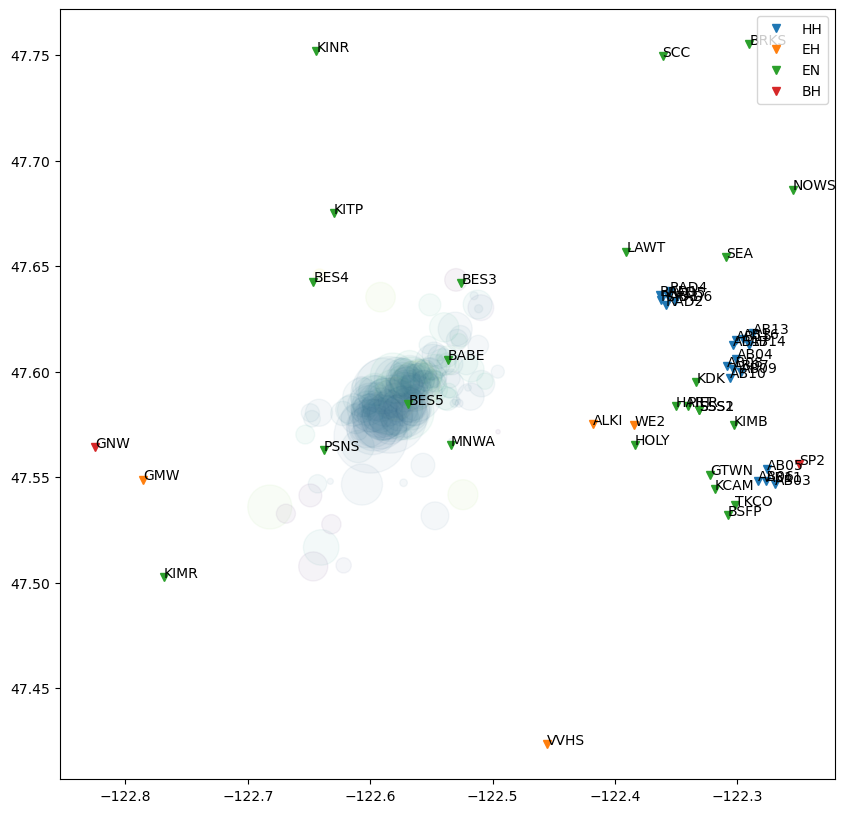

In [61]:
# Plot stations and events
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(df_EVE['Lon'],df_EVE['Lat'],c=df_EVE.index,s=(16*df_EVE['Magnitude'].values)**2,cmap='viridis',alpha=0.05)
for C_ in df_STA['Band/Inst Code'].unique():
    ind = df_STA['Band/Inst Code']==C_
    ax.plot(df_STA[ind]['longitude'],df_STA[ind]['latitude'],'v',ms=6,label=C_)

for i_ in range(len(df_STA)):
    ax.text(df_STA['longitude'].values[i_],df_STA['latitude'].values[i_],df_STA['station'].values[i_])
ax.legend()

# ax = fig.add_subplot(212)
px.scatter(df_EVE,x='Time UTC',y='Magnitude')


In [15]:
plt.figure()
px.scatter_geo(df_STA,lon='longitude',lat='latitude',color='network')
plt.show()

<Figure size 640x480 with 0 Axes>

# Produce a file list for rsync from a PNW_store server
**Note** this must to be run in a separate terminal for security reasons  
Command formula for remote --files-from `rsync` call:  
`rsync -v --files-from=pnws_query.txt {USR}@{SERVER ADDRESS}:{PATH TO PNW{YEAR} CONTAINING DIR} {DESTINATION}`

In [62]:
q_fmtstr =  'PNW{YEAR}/{NET}/{YEAR}/{JD}/{STA}.{NET}.{YEAR}.{JD}'
qlist = []

with open('./data/2017-05_BRM/pnws_query_big.txt','w') as f_:
    for J_ in range(62):
        JD = UTCDateTime("2017-05-01").julday + J_
        for N_ in inv.networks:
            for S_ in N_.stations:
                iquery = q_fmtstr.format(HDD='wd07',STA=S_.code,NET=N_.code,YEAR=2017,JD=JD)
                qlist.append(iquery)
                f_.write(iquery+'\n')

f_.close()
qlist

['PNW2017/GM/2017/121/AB03.GM.2017.121',
 'PNW2017/GM/2017/121/AB04.GM.2017.121',
 'PNW2017/GM/2017/121/AB05.GM.2017.121',
 'PNW2017/GM/2017/121/AB06.GM.2017.121',
 'PNW2017/GM/2017/121/AB07.GM.2017.121',
 'PNW2017/GM/2017/121/AB08.GM.2017.121',
 'PNW2017/GM/2017/121/AB09.GM.2017.121',
 'PNW2017/GM/2017/121/AB10.GM.2017.121',
 'PNW2017/GM/2017/121/AB11.GM.2017.121',
 'PNW2017/GM/2017/121/AB13.GM.2017.121',
 'PNW2017/GM/2017/121/AB14.GM.2017.121',
 'PNW2017/GM/2017/121/AB15.GM.2017.121',
 'PNW2017/GM/2017/121/AB16.GM.2017.121',
 'PNW2017/GM/2017/121/AB17.GM.2017.121',
 'PNW2017/GS/2017/121/WE2.GS.2017.121',
 'PNW2017/UW/2017/121/ALKI.UW.2017.121',
 'PNW2017/UW/2017/121/BABE.UW.2017.121',
 'PNW2017/UW/2017/121/BES3.UW.2017.121',
 'PNW2017/UW/2017/121/BES4.UW.2017.121',
 'PNW2017/UW/2017/121/BES5.UW.2017.121',
 'PNW2017/UW/2017/121/BRKS.UW.2017.121',
 'PNW2017/UW/2017/121/BSFP.UW.2017.121',
 'PNW2017/UW/2017/121/GMW.UW.2017.121',
 'PNW2017/UW/2017/121/GNW.UW.2017.121',
 'PNW2017/UW/2017/1

In [17]:
# Get continuous waveforms using BULK request - cross-reference with PNS Store holdings...
TSstr = "2017-05-11T00:00:00"
TEstr = "2017-05-13T00:00:00"

ts = UTCDateTime(TSstr)
te = ts + 3600.
out_file_FMT = os.path.join('data','2017-05_BRM','IRIS','{NET}','{STA}','{NET}.{STA}.{CP}.{TS}.{CHANS}.mseed')
bulk = []         
while ts < UTCDateTime(TEstr):
    print('Running window %s -- %s'%(ts.isoformat(),te.isoformat()))
    # Compose bulk request
    bulk = []
    for N_ in inv.networks:
        for S_ in N_.stations:
            try:
                os.makedirs(os.path.join('data','2017-05_BRM','IRIS',N_.code,S_.code))
            except:
                pass
            for C_ in S_.channels:
                CC_ = C_.code
                LC_ = C_.location_code
                bulk.append((N_.code,S_.code,LC_,CC_,ts,te))
    # Execute bulk request for chosen windowed timeframe for a given station
    st = client.get_waveforms_bulk(bulk)

    # Format and save waveforms in ML-compliant ordering - MSEED @ station level with Z,[N1],[E2] channel sequencing
    for N_ in inv.networks:
        for S_ in N_.stations:
            sst = st.copy().select(network=N_.code,station=S_.code)
            nchans = len(sst)

            # If 3-C station, bundle data as normal
            if nchans == 3:
                ist = Stream()
                ist += sst.select(channel='??Z')
                ist += sst.select(channel='??[N1]')
                ist += sst.select(channel='??[E1]')            
                CCODES = ist[0].stats.channel[-1] + ist[1].stats.channel[-1] + ist[2].stats.channel[-1]
                outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=sst[0].stats.channel[:2],CHANS=CCODES,TS=ts.isoformat())
                ist.write(outname,fmt='MSEED')
            # If 1-C station, use the "trick" from Retailleau et al. (2022)
            elif nchans == 1:
                ist = Stream()
                ist += sst[0]
                tr1f = sst[0].copy()
                tr1f.stats.channel+= 'N'  
                ist += tr1f
                tr2f = sst[0].copy()
                tr2f.stats.channel+= 'E'
                ist += tr2f
                CCODES = sst[0].stats.channel[-1] + 'ZZ'
                outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=sst[0].stats.channel[:2],CHANS=CCODES,TS=ts.isoformat())
                ist.write(outname,fmt='MSEED')
            # Deal with multi-sensor/-sampling_rate stations
            elif nchans > 3 and nchans%3 == 0:
                CPlist = []
                for C_ in S_.channels:
                    if C_.code[:2] not in CPlist:
                        CPlist.append(C_.code[:2])
                for CP_ in CPlist:
                    ist = Stream()
                    ist += sst.select(channel=CP_+'Z')
                    ist += sst.select(channel=CP_+'[N1]')
                    ist += sst.select(channel=CP_+'[E1]')            
                    CCODES = ist[0].stats.channel[-1] + ist[1].stats.channel[-1] + ist[2].stats.channel[-1]
                    outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=CP_,CHANS=CCODES,TS=ts.isoformat())
                    ist.write(outname,fmt='MSEED')
            
    # Advance indices for WHILE loop
    ts += 3600.
    te += 3600.



Running window 2017-05-11T00:00:00 -- 2017-05-11T01:00:00
Running window 2017-05-11T01:00:00 -- 2017-05-11T02:00:00
Running window 2017-05-11T02:00:00 -- 2017-05-11T03:00:00
Running window 2017-05-11T03:00:00 -- 2017-05-11T04:00:00
Running window 2017-05-11T04:00:00 -- 2017-05-11T05:00:00
Running window 2017-05-11T05:00:00 -- 2017-05-11T06:00:00
Running window 2017-05-11T06:00:00 -- 2017-05-11T07:00:00
Running window 2017-05-11T07:00:00 -- 2017-05-11T08:00:00
Running window 2017-05-11T08:00:00 -- 2017-05-11T09:00:00
Running window 2017-05-11T09:00:00 -- 2017-05-11T10:00:00
Running window 2017-05-11T10:00:00 -- 2017-05-11T11:00:00
Running window 2017-05-11T11:00:00 -- 2017-05-11T12:00:00
Running window 2017-05-11T12:00:00 -- 2017-05-11T13:00:00
Running window 2017-05-11T13:00:00 -- 2017-05-11T14:00:00
Running window 2017-05-11T14:00:00 -- 2017-05-11T15:00:00
Running window 2017-05-11T15:00:00 -- 2017-05-11T16:00:00
Running window 2017-05-11T16:00:00 -- 2017-05-11T17:00:00
Running window

### TRASH BEYOND HERE

In [ ]:
# # Use inventory to pull data for the period of interest and save to disk in 1 hour chunks
# ts = UTCDateTime(TSstr)
# te = ts + 3600.
# save_dir = os.path.join('data','2017-05_BRM')
# while ts < UTCDateTime(TEstr):
#     st = client.get_waveforms(starttime=ts,endtime=te)
#     ts += 3600.
#     te += 3600.


In [ ]:
# # Get continuous waveforms - OBSOLITED - This method fails to get extensive data
# ts = UTCDateTime(TSstr)
# te = ts + 3600.
# out_file_FMT = os.path.join('data','2017-05_BRM','{NET}','{STA}','{NET}.{STA}.{LOC}.{CHAN}.{TS}.mseed')
             
# while ts < UTCDateTime(TEstr):
#     print('Running window %s -- %s'%(ts.isoformat(),te.isoformat()))
#     for N_ in inv.networks:
#         # try:
#         #     os.makedirs(os.path.join('data','2017-05_BRM',str(N_.code)))
#         # except:
#         #     pass
#         for S_ in N_.stations:
#             st = Stream()
#             # try:
#             #     os.mkdir(os.path.join('data','2017-05_BRM',str(N_.code),str(S_.code)))
#             # except:
#             #     pass
#             for C_ in S_.channels:
#                 CC_ = C_.code
#                 LC_ = C_.location_code
#                 out_file = out_file_FMT.format(NET=N_.code,STA=S_.code,LOC=LC_,CHAN=CC_,TS=ts.isoformat())
#                 try:
#                     tr = client.get_waveforms(N_.code,S_.code,LC_,CC_,ts,te)[0]
#                     try: 
#                         os.mkdirs(os.path.join('data','2017-05_BRM',str(N_.code),str(S_.code)))
#                     except:
#                         pass
#                     tr.write(out_file,fmt='MSEED')
#                 except:
#                     pass
#     ts += 3600.
#     te += 3600.

In [ ]:
# # Use IRIS webservices / FDSN to query waveform data 
# # Based on mass_downloader example on docs.github.org: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html
# domain = CircularDomain(**dict((k_,qstation_kwargs[k_]) for k_ in ['latitude','longitude','maxradius']),minradius=.0)

# restrictions = Restrictions(starttime=UTCDateTime(TSstr),endtime=UTCDateTime(TEstr),
#                             chunklength_in_sec=3600.)
#                             # limit_stations_to_inventory=inv,chunklength_in_sec=3600)
# mdl = MassDownloader()
# mdl.download(domain,restrictions,threads_per_client=2,\
#              mseed_storage=os.path.join('data','2017-05_BRM'),\
#              stationxml_storage=os.path.join('data','2017-05_BRM','{network}','{station}.xml'))

In [ ]:
# # Plot the catalog
# fig = plt.figure(figsize=(10,10))
# axa = fig.add_subplot(211)
# axa.plot(df_BRM_full['Magnitude'],'.')
# axa.set_xlabel('UTC Date Time')
# axa.set_ylabel('Magnitude (mixed methods)')
# axb = axa.twinx()
# axb.plot(df_BRM_full['Magnitude'].cumsum(),'r-',alpha=0.5)
# axb.set_ylabel('Cumulative magnitude',labelpad=15)

# # # Define window to assess
# # TS = pd.Timestamp("2017-05-11")
# # TE = pd.Timestamp("2017-05-13T00:00:00")

# axa.fill_between([TS,TE],[axa.get_ylim()[0]]*2,[axa.get_ylim()[1]]*2,color='yellow')


# axc = fig.add_subplot(212)
# IND = (df_BRM_full.index >= TS) & (df_BRM_full.index <= TE)
# axc.plot(df_BRM_full[IND]['Magnitude'],'.')
# axd = axc.twinx()
# axd.plot((10**df_BRM_full[IND]['Magnitude']).cumsum(),'r-',alpha=0.5)

# # axc = fig.add_subplot(223)
# # ch = axc.scatter(df_BRM_full['Lon'],df_BRM_full['Lat'],s = 5**df_BRM_full['Magnitude'],c=df_BRM_full.index)
# # plt.colorbar(ax=axc,cax=ch)